In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [7]:
Sales = pd.read_excel("SalesData.xlsx",sheet_name="Orders" )

In [8]:
Sales_1 = Sales[["Order_Date","Region","Category","Sales"]]

In [17]:
Sales_1['Order_Date'] = pd.to_datetime(Sales_1['Order_Date'])  # convert date column to datetime format
Sales_1['week_year'] = Sales_1['Order_Date'].apply(lambda x: x.strftime('%U-%Y'))  # extract week and year
Sales_1['month_end_date'] = Sales_1['Order_Date'].apply(lambda x: (x + pd.offsets.MonthEnd(1)) - pd.offsets.Day(1))
Sales_1['weekend_date'] = Sales_1['Order_Date'] - pd.to_timedelta(Sales_1['Order_Date'].dt.dayofweek, unit='D')+pd.DateOffset(weeks=1)-pd.DateOffset(days=1)


/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/4291041262.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_1['Order_Date'] = pd.to_datetime(Sales_1['Order_Date'])  # convert date column to datetime format
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/4291041262.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_1['week_year'] = Sales_1['Order_Date'].apply(lambda x: x.strftime('%U-%Y'))  # extract week and year
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000g

In [18]:
Sales_1

,Order_Date,Region,Category,Sales,week_year,month_end_date,weekend_date
0,2016-11-08,South,Furniture,261.9600,45-2016,2016-11-29,2016-11-13
1,2016-11-08,South,Furniture,731.9400,45-2016,2016-11-29,2016-11-13
2,2016-06-12,West,Office Supplies,14.6200,24-2016,2016-06-29,2016-06-12
3,2015-10-11,South,Furniture,957.5775,41-2015,2015-10-30,2015-10-11
4,2015-10-11,South,Office Supplies,22.3680,41-2015,2015-10-30,2015-10-11
...,...,...,...,...,...,...,...
9989,2014-01-21,South,Furniture,25.2480,03-2014,2014-01-30,2014-01-26
9990,2017-02-26,West,Furniture,91.9600,09-2017,2017-02-27,2017-02-26
9991,2017-02-26,West,Technology,258.5760,09-2017,2017-02-27,2017-02-26
9992,2017-02-26,West,Office Supplies,29.6000,09-2017,2017-02-27,2017-02-26


In [19]:
region_category_pairs = Sales_1[['Region', 'Category']].drop_duplicates()

In [20]:
region_category_pairs

,Region,Category
0,South,Furniture
2,West,Office Supplies
4,South,Office Supplies
5,West,Furniture
7,West,Technology
14,Central,Office Supplies
23,East,Furniture
28,East,Office Supplies
35,Central,Technology
36,Central,Furniture


In [21]:
time_series_d=[]
time_series_w=[]
time_series_m=[]
for pair in region_category_pairs.itertuples():
    region = pair[1]
    category = pair[2]
    
    # filter the sales data by the current Region and Category
    subset_df = Sales_1[(Sales_1['Region'] == region) & (Sales_1['Category'] == category)]
    subset_df_d = subset_df.groupby('Order_Date')['Sales'].sum()
    subset_df_w = subset_df.groupby('weekend_date')['Sales'].sum()
    subset_df_m = subset_df.groupby('month_end_date')['Sales'].sum()
    time_series_d.append(subset_df_d)
    time_series_w.append(subset_df_w)
    time_series_m.append(subset_df_m)

/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return n

ValueError: x and y must have same first dimension, but have shapes (4,) and (16,)

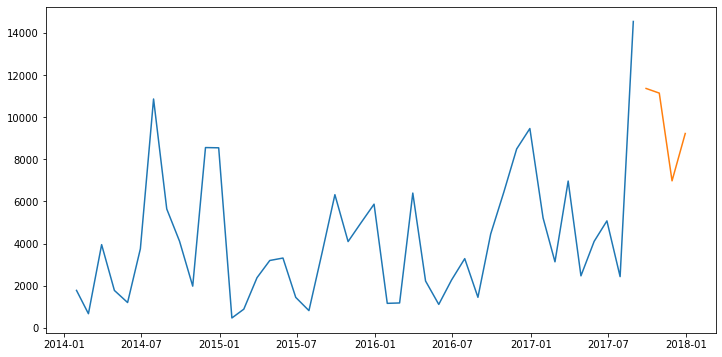

In [22]:
i=1
train_data = time_series_m[i].iloc[:-4]
test_data = time_series_m[i].iloc[-4:]
model = pm.auto_arima(train_data, seasonal=True, m=12,suppress_warnings=True)
forecast = model.predict(n_periods=len(test_data)+12,index=test_data.index,exogenous=test_data)
# forecast_df.index = pd.date_range(start='2018-01-31', periods=12, freq='M')
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=['predictions'])
fitted_values = model.predict_in_sample()
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='Forecast')
plt.plot(train_data.index, fitted_values, label = "Fitted")
plt.title("Region - South & Category - Furniture")
plt.legend()
plt.show()

/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


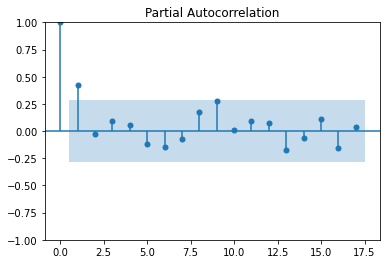

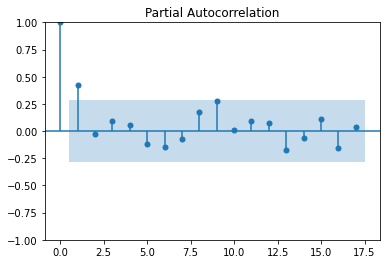

In [23]:
plot_pacf(time_series_m[i])

In [24]:
print(test_data.index)

DatetimeIndex(['2017-09-29', '2017-10-30', '2017-11-29', '2017-12-30'], dtype='datetime64[ns]', name='month_end_date', freq=None)


In [25]:
forecast_data = pd.DataFrame()
forecast_data.index = pd.date_range(start='2018-01-31', periods=12, freq='M')

In [26]:
print(forecast_data.index)

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')


###  TRYING TO FORECAST SALES USING ARIMA (APPENDIX STUFF)

/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


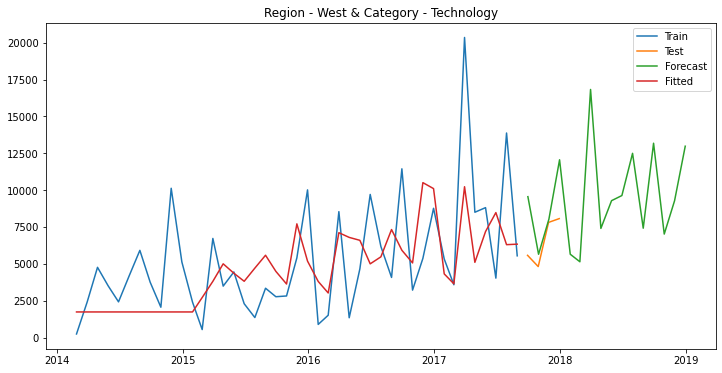

In [27]:
#i=0: South & Office Supplies
i=4
train_data = time_series_m[i].iloc[:-4]
test_data = time_series_m[i].iloc[-4:]
model = pm.auto_arima(train_data, seasonal=True, m=12,suppress_warnings=True)
forecast = model.predict(n_periods=16,index=pd.date_range(start='2017-09-29', periods=16, freq='M'),exogenous=test_data)
#forecast_df.index = pd.date_range(start='2018-01-31', periods=12, freq='M')
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='2017-09-29', periods=16, freq='M'), columns=['predictions'])
fitted_values = model.predict_in_sample()
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_df.index, forecast, label='Forecast')
plt.plot(train_data.index, fitted_values, label = "Fitted")
plt.title("Region - West & Category - Technology")
plt.legend()
plt.show()

In [28]:
prev3m = time_series_m[i].iloc[-3:].sum()
prev6m = time_series_m[i].iloc[-6:].sum()
prev9m = time_series_m[i].iloc[-9:].sum()
prev12m = time_series_m[i].iloc[-12:].sum()

post3m = forecast.iloc[4:7].sum()
post6m = forecast.iloc[4:10].sum()
post9m = forecast.iloc[4:13].sum()
post12m = forecast.iloc[4:16].sum()

In [29]:
print("Prev3m is: ",prev3m)
print("prev6m is: ",prev6m)
print("prev9m is: ",prev9m)
print("prev12m is: ",prev12m)
print("post3m is: ",post3m)
print("post6m is: ",post6m)
print("post9m is: ",post9m)
print("post12m is: ",post12m)

Prev3m is:  20684.471
prev6m is:  45671.573
prev9m is:  67004.678
prev12m is:  96261.524
post3m is:  27612.10891650272
post6m is:  53923.954212018856
post9m is:  87010.8153567215
post12m is:  116280.22817844708


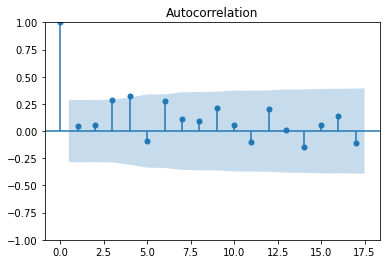

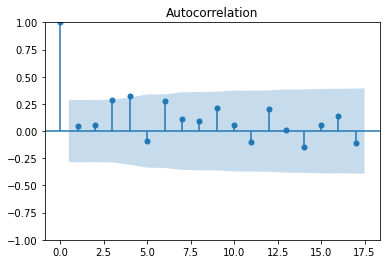

In [30]:
plot_acf(time_series_m[i])

/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


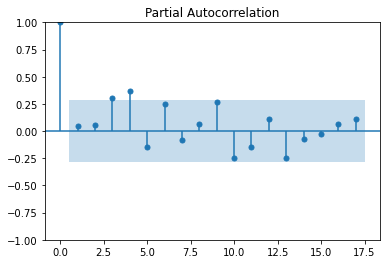

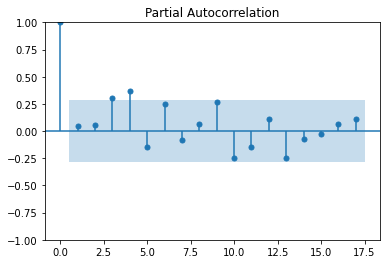

In [31]:
plot_pacf(time_series_m[i])

### Trying to forecast profit instead of sales

/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/1224423943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_1['Order_Date'] = pd.to_datetime(Sales_1['Order_Date'])  # convert date column to datetime format
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/1224423943.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Sales_1['week_year'] = Sales_1['Order_Date'].apply(lambda x: x.strftime('%U-%Y'))  # extract week and year
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000g

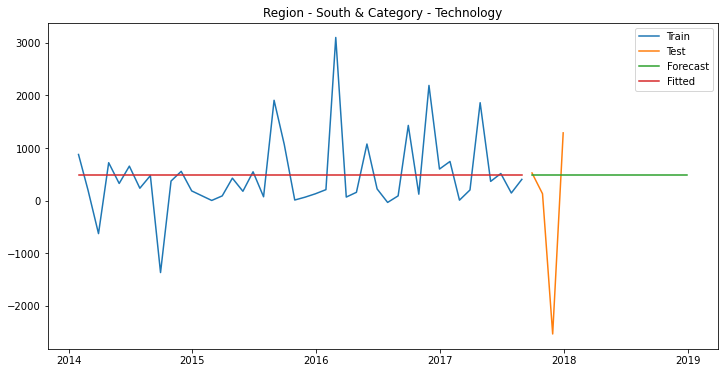

In [32]:
Sales_1 = Sales[["Order_Date","Region","Category","Profit"]]
Sales_1['Order_Date'] = pd.to_datetime(Sales_1['Order_Date'])  # convert date column to datetime format
Sales_1['week_year'] = Sales_1['Order_Date'].apply(lambda x: x.strftime('%U-%Y'))  # extract week and year
Sales_1['month_end_date'] = Sales_1['Order_Date'].apply(lambda x: (x + pd.offsets.MonthEnd(1)) - pd.offsets.Day(1))
Sales_1['weekend_date'] = Sales_1['Order_Date'] - pd.to_timedelta(Sales_1['Order_Date'].dt.dayofweek, unit='D')+pd.DateOffset(weeks=1)-pd.DateOffset(days=1)
time_series_d=[]
time_series_w=[]
time_series_m=[]
for pair in region_category_pairs.itertuples():
    region = pair[1]
    category = pair[2]
    
    # filter the sales data by the current Region and Category
    subset_df = Sales_1[(Sales_1['Region'] == region) & (Sales_1['Category'] == category)]
    subset_df_d = subset_df.groupby('Order_Date')['Profit'].sum()
    subset_df_w = subset_df.groupby('weekend_date')['Profit'].sum()
    subset_df_m = subset_df.groupby('month_end_date')['Profit'].sum()
    time_series_d.append(subset_df_d)
    time_series_w.append(subset_df_w)
    time_series_m.append(subset_df_m)

    
#i=0: South & Office Supplies
i=11
train_data = time_series_m[i].iloc[:-4]
test_data = time_series_m[i].iloc[-4:]
model = pm.auto_arima(train_data, seasonal=True, m=12,suppress_warnings=True)
forecast = model.predict(n_periods=16,index=pd.date_range(start='2017-09-29', periods=16, freq='M'),exogenous=test_data)
#forecast_df.index = pd.date_range(start='2018-01-31', periods=12, freq='M')
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='2017-09-29', periods=16, freq='M'), columns=['predictions'])
fitted_values = model.predict_in_sample()
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_df.index, forecast, label='Forecast')
plt.plot(train_data.index, fitted_values, label = "Fitted")
plt.title("Region - South & Category - Technology")
plt.legend()
plt.show()


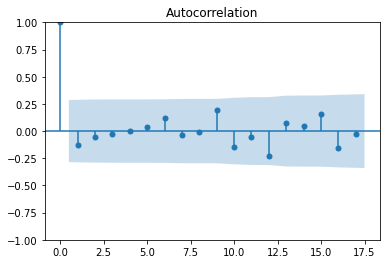

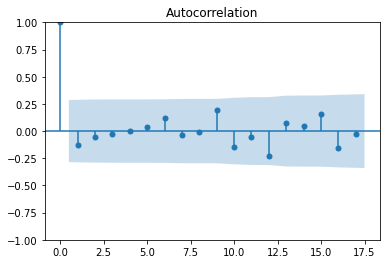

In [33]:
plot_acf(time_series_m[i])

/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


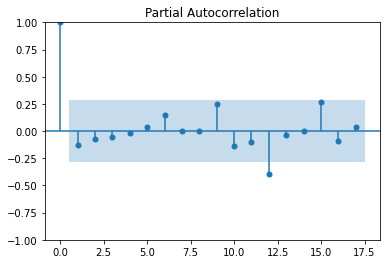

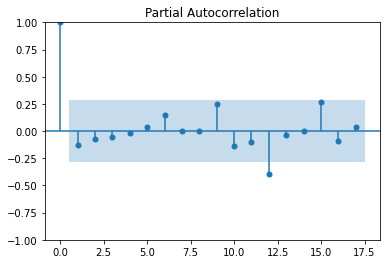

In [34]:
plot_pacf(time_series_m[i])

In [35]:
prev3m = time_series_m[i].iloc[-3:].sum()
prev6m = time_series_m[i].iloc[-6:].sum()
prev9m = time_series_m[i].iloc[-9:].sum()
prev12m = time_series_m[i].iloc[-12:].sum()

post3m = forecast.iloc[4:7].sum()
post6m = forecast.iloc[4:10].sum()
post9m = forecast.iloc[4:13].sum()
post12m = forecast.iloc[4:16].sum()

print("Prev3m is: ",prev3m)
print("prev6m is: ",prev6m)
print("prev9m is: ",prev9m)
print("prev12m is: ",prev12m)
print("post3m is: ",post3m)
print("post6m is: ",post6m)
print("post9m is: ",post9m)
print("post12m is: ",post12m)

Prev3m is:  -1117.607299999999
prev6m is:  -43.916699999998855
prev9m is:  2697.7847000000006
prev12m is:  3652.8888000000015
post3m is:  1436.095834883721
post6m is:  2872.1916697674415
post9m is:  4308.287504651163
post12m is:  5744.383339534883


# PROFIT MODELLING USING EXPONENTIAL SMOOTHING

/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/1360078761.py:10: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train_data, trend='add', seasonal='add', damped=False, seasonal_periods=seasonality_period, initialization_method='estimated')
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/1360078761.py:11: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is availabl

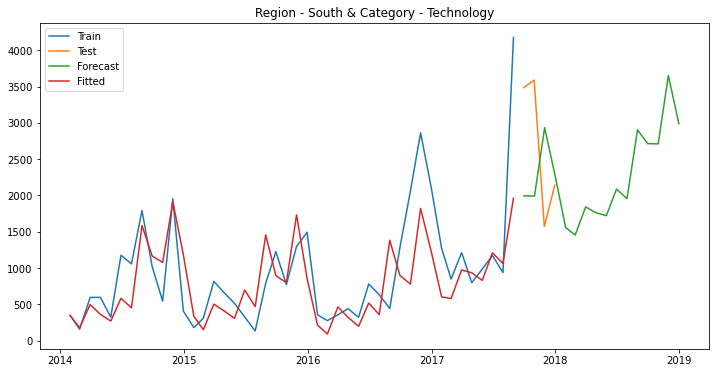

In [36]:
##USING TRIAL ERROR & FINDING PARAMETERS
#i=0: South & Office Supplies
i=1
train_data = time_series_m[i].iloc[:-4]
test_data = time_series_m[i].iloc[-4:]
alpha = 0.1  # smoothing parameter
beta = 0.1
gamma = 0.1
seasonality_period = 12
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', damped=False, seasonal_periods=seasonality_period, initialization_method='estimated')
model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
forecast = model_fit.forecast(steps=16)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='2017-09-29', periods=16, freq='M'), columns=['predictions'])
fitted_values = model_fit.fittedvalues
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_df.index, forecast, label='Forecast')
plt.plot(train_data.index, fitted_values, label = "Fitted")
plt.title("Region - South & Category - Technology")
plt.legend()
plt.show()

In [37]:
##USING PARAMETER GRID SEARCH FOR BEST ALPHA BETA GAMMA

i=11
train_data = time_series_m[i].iloc[:-4]
test_data = time_series_m[i].iloc[-4:]

param_grid = {'alpha': [0.1, 0.2, 0.3],
              'beta': [0.1, 0.2, 0.3],
              'gamma': [0.1, 0.2, 0.3]}
param_combinations = list(ParameterGrid(param_grid))
model = ExponentialSmoothing(train_data, trend='add', seasonal='add', damped=False, seasonal_periods=seasonality_period, initialization_method='estimated')
best_rmse = float('inf')
for params in param_combinations:
    model_fit = model.fit(smoothing_level=params['alpha'], smoothing_slope=params['beta'], smoothing_seasonal=params['gamma'])
    y_pred = model_fit.forecast(steps=len(df))
    rmse = np.sqrt(mean_squared_error(test_data, forecast.iloc[0:4]))
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        
seasonality_period = 12

model_fit = model.fit(smoothing_level=best_params['alpha'], smoothing_slope=best_params['beta'], smoothing_seasonal=best_params['gamma'])
forecast = model_fit.forecast(steps=16)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start='2017-09-29', periods=16, freq='M'), columns=['predictions'])
fitted_values = model_fit.fittedvalues
fig = plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_df.index, forecast, label='Forecast')
plt.plot(train_data.index, fitted_values, label = "Fitted")
plt.title("Region - South & Category - Technology")
plt.legend()
plt.show()

/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/3463012733.py:11: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead.
  model = ExponentialSmoothing(train_data, trend='add', seasonal='add', damped=False, seasonal_periods=seasonality_period, initialization_method='estimated')
/Users/niharika/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/_z/q96ykqsn38n8hwt_d86n8g800000gn/T/ipykernel_89260/3463012733.py:14: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  model_fit = model.fit(smoothing_level=params['alpha'], smoothing_slope=params['beta'], smoothing_seasonal=params['gamma'])


NameError: name 'df' is not defined

In [38]:
prev3m = time_series_m[i].iloc[-3:].sum()
prev6m = time_series_m[i].iloc[-6:].sum()
prev9m = time_series_m[i].iloc[-9:].sum()
prev12m = time_series_m[i].iloc[-12:].sum()

post3m = forecast.iloc[4:7].sum()
post6m = forecast.iloc[4:10].sum()
post9m = forecast.iloc[4:13].sum()
post12m = forecast.iloc[4:16].sum()

print("Prev3m is: ",prev3m)
print("prev6m is: ",prev6m)
print("prev9m is: ",prev9m)
print("prev12m is: ",prev12m)
print("post3m is: ",post3m)
print("post6m is: ",post6m)
print("post9m is: ",post9m)
print("post12m is: ",post12m)

Prev3m is:  -1117.607299999999
prev6m is:  -43.916699999998855
prev9m is:  2697.7847000000006
prev12m is:  3652.8888000000015
post3m is:  4854.549286033774
post6m is:  10425.782386693058
post9m is:  17998.98242821015
post12m is:  27350.005276744683
